**Description:**
  * Creating a synthetic feature that is the ratio of two other features
  * Using this new feature as an input to a linear regression model
  * Improving the effectiveness of the model by identifying and clipping (removing) outliers out of the input data

In [1]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
11942,-121.4,38.6,37.0,2839.0,390.0,1006.0,400.0,7.3,280.4
9825,-119.7,34.4,30.0,1273.0,343.0,1082.0,325.0,2.5,228.1
857,-117.1,32.6,21.0,1779.0,466.0,1327.0,488.0,1.6,96.2
2669,-117.7,33.5,24.0,3571.0,722.0,1409.0,543.0,4.7,277.8
6462,-118.3,34.1,46.0,3007.0,854.0,2587.0,814.0,2.7,184.3
...,...,...,...,...,...,...,...,...,...
12964,-121.8,37.2,6.0,9176.0,1201.0,3637.0,1138.0,8.4,473.4
13495,-122.0,37.9,10.0,3209.0,379.0,1199.0,392.0,12.2,500.0
16803,-123.2,39.1,30.0,1904.0,331.0,816.0,325.0,4.4,161.9
11758,-121.3,39.3,11.0,2640.0,505.0,1257.0,445.0,3.6,112.0


In [2]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [3]:
def train_model(learning_rate, steps, batch_size, input_feature):
  periods = 10
  steps_per_period = steps / periods
  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    root_mean_squared_errors.append(root_mean_squared_error)
    y_extents = np.array([0, sample[my_label].max()]) 
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')  
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())
  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error) 
  return calibration_data

Training model...
RMSE (on training data):
  period 00 : 212.74
  period 01 : 190.48
  period 02 : 169.69
  period 03 : 152.27
  period 04 : 140.87
  period 05 : 134.13
  period 06 : 131.28
  period 07 : 130.94
  period 08 : 131.95
  period 09 : 133.06
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,201.2,207.3
std,93.2,116.0
min,44.6,15.0
25%,164.6,119.4
50%,198.0,180.4
75%,226.4,265.0
max,4446.9,500.0


Final RMSE (on training data): 133.06


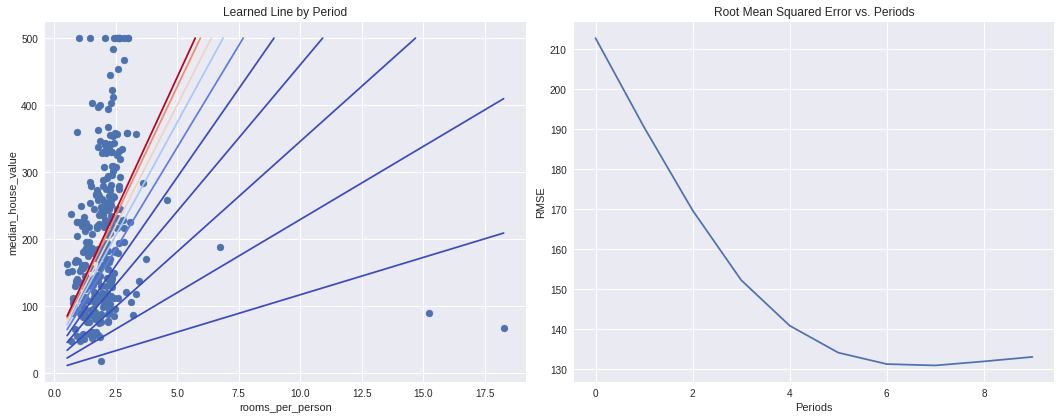

In [4]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

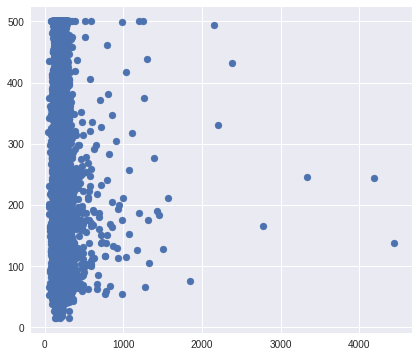

In [5]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

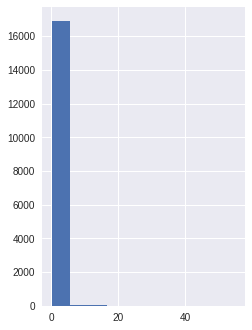

In [6]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

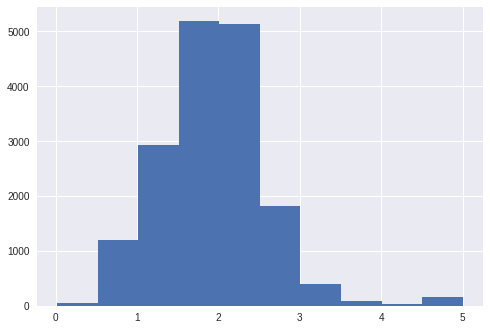

In [7]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))
_ = california_housing_dataframe["rooms_per_person"].hist()

Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 189.05
  period 02 : 166.70
  period 03 : 147.08
  period 04 : 131.28
  period 05 : 120.51
  period 06 : 114.98
  period 07 : 111.50
  period 08 : 108.90
  period 09 : 108.05
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,197.6,207.3
std,51.7,116.0
min,46.1,15.0
25%,164.6,119.4
50%,197.6,180.4
75%,225.7,265.0
max,438.6,500.0


Final RMSE (on training data): 108.05


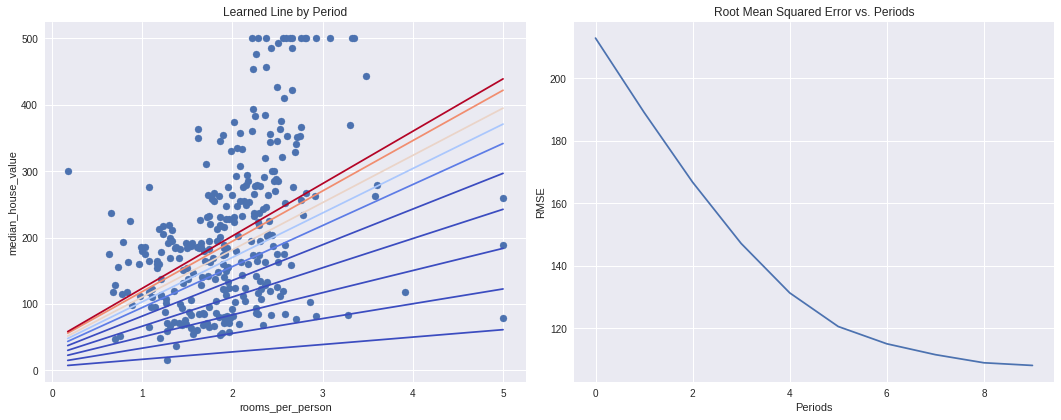

In [8]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

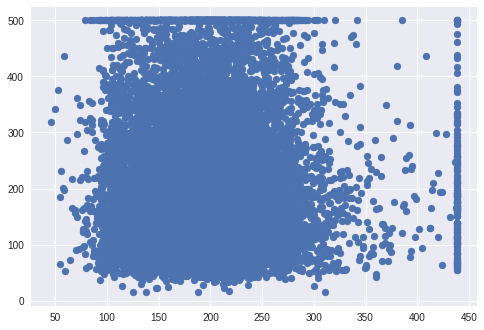

In [9]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])